In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path

workding_dir = str(Path.cwd().parent)
os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

workding dir: /Users/inflaton/code/engd/papers/maritime/global-incidents
loading env vars from: /Users/inflaton/code/engd/papers/maritime/global-incidents/.env


True

In [2]:
import nltk
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import contractions

import gensim
from gensim import corpora
from gensim import similarities
from gensim import models
from gensim.models import CoherenceModel

# from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import os
import glob
import json

import pickle
from datetime import datetime
import datetime

# Import Data

In [3]:
df = pd.read_csv("data/scrapped_data2.csv")

# EDA

In [4]:
df.head()

id                                           Headline  \
0   1  Grasberg Mine- Grasberg mine workers extend st...   
1   2  Indonesia: Undersea internet cables damaged by...   
2   3  Shanghai port congestion impacts terminals in ...   
3   4  UPDATE - Indonesia: Explosion at KP Terminal i...   
4   5  UPDATE - Indonesia: Police confirm two explosi...   

                                             Details  Severity  \
0  Media sources indicate that workers at the Gra...  Moderate   
1  News sources are stating that recent typhoons ...     Minor   
2  The persisting port congestion at Shanghai’s Y...     Minor   
3  Updated local media sources from Jakarta indic...   Extreme   
4  According to local police in Jakarta, two expl...   Extreme   

                     Category     Region       Datetime    Year       lat  \
0         Mine Workers Strike  Indonesia  28/5/17 17:08  2017.0  -4.05608   
1              Travel Warning  Indonesia   4/9/17 14:30  2017.0       NaN   
2             Port Congestion      China   27/4/17 9:16  2017.0  29.52000   
3  Bombing, Police Operations  Indonesia  24/5/17 15:15  2017.0  -6.22465   
4  Bombing, Police Operations  Indonesia  24/5/17 16:20  2017.0       NaN   

         lon  maritime_label                        found_ports  \
0  137.11302           False                       ['freeport']   
1        NaN           False                      ['hong kong']   
2  121.33190            True  ['ningbo', 'qingdao', 'shanghai']   
3  106.86700            True                        ['jakarta']   
4        NaN            True                        ['jakarta']   

   contains_port_info if_labeled  Month  Week  \
0                 1.0      False    5.0  21.0   
1                 1.0      False    4.0  14.0   
2                 1.0      False    4.0  17.0   
3                 1.0      False    5.0  21.0   
4                 1.0       True    5.0  21.0   

                                    Headline_Details  \
0  Grasberg Mine- Grasberg mine workers extend st...   
1  Indonesia: Undersea internet cables damaged by...   
2  Shanghai port congestion impacts terminals in ...   
3  UPDATE - Indonesia: Explosion at KP Terminal i...   
4  UPDATE - Indonesia: Police confirm two explosi...   

                                                 url  \
0  https://news.google.com/rss/articles/CBMiZ2h0d...   
1                                       no url found   
2  https://news.google.com/rss/articles/CBMiVWh0d...   
3                                       no url found   
4  https://news.google.com/rss/articles/CBMiZWh0d...   

                                               title  \
0  Freeport Indonesia mine workers extend strike ...   
1                                     no title found   
2  Typhoon Muifa to shut China ports for second t...   
3                                     no title found   
4  Jakarta Police Receive 2 More Reports on Coldp...   

                                             content  
0  Trucks are seen on a road in the Grasberg copp...  
1                                   no content found  
2  By Sam Whelan 13/09/2022\n\nAnother typhoon ha...  
3                                   no content found  
4  TEMPO.CO, Jakarta - South Jakarta Metro Police...

In [5]:
df.shape

(5710, 20)

In [6]:
df_copy = df.copy()

In [7]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5710 entries, 0 to 5709
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  5710 non-null   int64  
 1   Headline            5710 non-null   object 
 2   Details             5710 non-null   object 
 3   Severity            5710 non-null   object 
 4   Category            5710 non-null   object 
 5   Region              5710 non-null   object 
 6   Datetime            5710 non-null   object 
 7   Year                5710 non-null   float64
 8   lat                 3840 non-null   float64
 9   lon                 3840 non-null   float64
 10  maritime_label      5710 non-null   bool   
 11  found_ports         5708 non-null   object 
 12  contains_port_info  5708 non-null   float64
 13  if_labeled          5708 non-null   object 
 14  Month               5708 non-null   float64
 15  Week                5708 non-null   float64
 16  Headli

In [8]:
df_copy.isnull().sum()

id                       0
Headline                 0
Details                  0
Severity                 0
Category                 0
Region                   0
Datetime                 0
Year                     0
lat                   1870
lon                   1870
maritime_label           0
found_ports              2
contains_port_info       2
if_labeled               2
Month                    2
Week                     2
Headline_Details         2
url                      0
title                    4
content                 10
dtype: int64

In [9]:
# drop empty lines
df_copy.dropna(subset=["Headline"], inplace=True)

In [10]:
print("Published Date Statistics:")
print("Min Date:", df_copy["Datetime"].min())
print("Max Date:", df_copy["Datetime"].max())

Published Date Statistics:
Min Date: 1/1/20 11:07
Max Date: 9/9/20 6:54


In [11]:
# Check if there are any duplicated titles since a news can be published for multiple times by different publisher at different time
df_copy[["Year", "Headline", "Region"]].duplicated().any()

False

In [12]:
# drop the duplicated news
duplicates = df_copy.duplicated(subset=["Year", "Headline", "Region"], keep="first")
df_uni = df_copy[~duplicates]

In [13]:
df_uni = df_uni[
    ~df_uni["content"].isin(["cannot scrape the content", "no content found"])
]

In [14]:
df_uni.shape

(3694, 20)

In [15]:
df_uni[df_uni["title"].isnull()]

id                                           Headline  \
1358  1373  Cocaine Seizures at Brazil Ports Rose by 50 Pe...   
3291  3339  Congestion and cargo disruptions ongoing at Po...   
3302  3351  Constrained ocean freight capacity reported at...   
4913  4978  At the Smart Port Challenge 2020, the Senior M...   

                                                Details  Severity  \
1358  Brazil s Department of Federal Revenue (RFB) r...  Moderate   
3291  Sources indicated on February 27 that congeste...  Moderate   
3302  Sources indicate that the Port of Incheon is c...  Moderate   
4913  At the Smart Port Challenge 2020, the Senior M...     Minor   

                                               Category             Region  \
1358                               Miscellaneous Events             Brazil   
3291  Port Congestion, Cargo Disruption, Port Disrup...             Canada   
3302                                   Cargo Disruption  Republic of Korea   
4913  Miscellaneous Events, Political Info / Event, ...          Singapore   

            Datetime    Year       lat        lon  maritime_label  \
1358  18/11/19 15:43  2019.0 -23.96144  -46.32807            True   
3291   27/2/20 19:24  2020.0       NaN        NaN           False   
3302   26/2/20 22:39  2020.0  37.43922  126.59753           False   
4913  19/11/20 13:26  2020.0       NaN        NaN           False   

        found_ports  contains_port_info if_labeled  Month  Week  \
1358     ['santos']                 1.0      False   11.0  47.0   
3291  ['vancouver']                 1.0       True    2.0   9.0   
3302    ['incheon']                 1.0      False    2.0   9.0   
4913  ['singapore']                 1.0       True   11.0  47.0   

                                       Headline_Details  \
1358  Cocaine Seizures at Brazil Ports Rose by 50 Pe...   
3291  Congestion and cargo disruptions ongoing at Po...   
3302  Constrained ocean freight capacity reported at...   
4913  At the Smart Port Challenge 2020, the Senior M...   

                                                    url title  \
1358  https://news.google.com/rss/articles/CBMiWGh0d...   NaN   
3291  https://news.google.com/rss/articles/CBMidWh0d...   NaN   
3302  https://news.google.com/rss/articles/CBMiXmh0d...   NaN   
4913  https://news.google.com/rss/articles/CBMiO2h0d...   NaN   

                                                content  
1358                                                NaN  
3291  Source: Shutterstock\n\nOngoing strike action ...  
3302  Image: Shutterstock\n\nCapacity constraints an...  
4913  Ministry of Road Transport & Highways Year End...

In [16]:
df_uni[df_uni["url"].isnull()]

Empty DataFrame
Columns: [id, Headline, Details, Severity, Category, Region, Datetime, Year, lat, lon, maritime_label, found_ports, contains_port_info, if_labeled, Month, Week, Headline_Details, url, title, content]
Index: []

In [17]:
df_uni[df_uni["content"].isnull()]

id                                           Headline  \
346    350  Large fire destroys a fabric warehouse in Ho C...   
1358  1373  Cocaine Seizures at Brazil Ports Rose by 50 Pe...   
1462  1477  Dredging works planned at Port of Melbourne fr...   
1463  1478  Drilling ship Patra developed heavy portside l...   
1786  1806  Massive fire destroys 30 vessels at Muara Baru...   
2032  2058              Port of Gdansk faces berth congestion   
4754  4818  UPDATE 8 - Average delays decrease to 16 hours...   
5005  5070  CSL Manhattan container ship goes into 14 day ...   
5443  5513  The Ministry of Agricultural Development (Mida...   
5475  5545  Tsingtao Express container ship could go into ...   

                                                Details  Severity  \
346   Vietnamese media sources reported that a large...     Minor   
1358  Brazil s Department of Federal Revenue (RFB) r...  Moderate   
1462  Industry sources indicated that planned dredgi...     Minor   
1463  Media sources reported that drilling ship, Pat...     Minor   
1786  According to Indonesian media sources, local a...     Minor   
2032  Berth congestion has been reported at Port of ...  Moderate   
4754  Updated industry sources report on October 27 ...  Moderate   
5005  Shipping sources indicate that the CSL Manhatt...  Moderate   
5443  The Ministry of Agricultural Development (Mida...     Minor   
5475  Shipping sources indicate that the Tsingtao Ex...  Moderate   

                                               Category             Region  \
346                                     Industrial Fire           Viet Nam   
1358                               Miscellaneous Events             Brazil   
1462                                    Port Disruption          Australia   
1463                                  Maritime Accident             Taiwan   
1786               Port Disruption, Non-industrial Fire          Indonesia   
2032                                    Port Congestion             Poland   
4754                                    Port Congestion           Malaysia   
5005             Maritime Accident, Outbreak of disease              China   
5443  Miscellaneous Events, Political Info / Event, ...             Panama   
5475                                  Maritime Advisory  Republic of Korea   

            Datetime    Year       lat        lon  maritime_label  \
346     25/9/18 8:45  2018.0  10.84925  106.69308           False   
1358  18/11/19 15:43  2019.0 -23.96144  -46.32807            True   
1462   27/11/19 2:42  2019.0 -37.81000  144.91000           False   
1463    23/8/19 8:41  2019.0  24.20008  120.44838           False   
1786    26/2/19 6:08  2019.0  -6.10102  106.80425           False   
2032    12/2/19 5:47  2019.0  54.40345   18.67027           False   
4754    29/9/20 3:45  2020.0       NaN        NaN            True   
5005  18/11/20 20:31  2020.0       NaN        NaN            True   
5443  17/11/20 19:26  2020.0       NaN        NaN           False   
5475  19/11/20 16:18  2020.0       NaN        NaN            True   

                            found_ports  contains_port_info if_labeled  Month  \
346                     ['ho chi minh']                 1.0       True    9.0   
1358                         ['santos']                 1.0      False   11.0   
1462                      ['melbourne']                 1.0      False   11.0   
1463                       ['taichung']                 1.0      False    8.0   
1786               ['jakarta', 'muara']                 1.0       True    2.0   
2032                         ['gdansk']                 1.0      False   12.0   
4754                     ['port klang']                 1.0       True    9.0   
5005                       ['shanghai']                 1.0      False   11.0   
5443  ['balboa', 'colón', 'manzanillo']                 1.0      False   11.0   
5475              ['busan', 'tsingtao']                 1.0      False   11.0   

      Week           

In [18]:
# drop empty lines
df_uni.dropna(subset=["title", "content"], inplace=True)

In [20]:
df_uni.shape

(3681, 20)

# Text Preprocessing
contractions -> punctuation removal -> lowercase -> -> lemmanisation -> stop words removal + bigram

In [21]:
df_uni["content"][5]

'A man stands near damaged houses following a tornado at Sukadana village in Sumedang, West Java province\n\nIndonesia has been struck by some of the strongest winds recorded in the country, injuring at least 33 people.\n\nBuildings were damaged as the winds tore through the town of Sumedang in West Java province.\n\nVideos uploaded to social media show debris flying through the air, roofs torn from buildings and part of a convenience store collapsing.\n\nA climatologist at government research body BRIN said winds were strong enough to be considered a tornado.\n\n"My father was sitting in our terrace and suddenly he saw plastic just flying and twisting. Not long after that, the strong wind came near my house," Kay Tiara, a Sumedang resident, told Reuters.\n\n"The roof of my house immediately flew away. My family and I took cover inside my house," she added.\n\nIndonesia\'s disaster mitigation agency said no serious injuries have been reported.\n\nErma Yulihastin, a climatologist at BRI

In [22]:
## remove contractions, lowercase, remove numbers and punctuations, remove stopwords
df_uni["cleaned_content"] = df_uni["content"].apply(
    lambda x: [contractions.fix(word) for word in x.split()]
)

## convert back into string so that tokenization can be done
df_uni["cleaned_content"] = [" ".join(map(str, l)) for l in df_uni["cleaned_content"]]

In [23]:
df_uni["cleaned_content"][5]

'A man stands near damaged houses following a tornado at Sukadana village in Sumedang, West Java province Indonesia has been struck by some of the strongest winds recorded in the country, injuring at least 33 people. Buildings were damaged as the winds tore through the town of Sumedang in West Java province. Videos uploaded to social media show debris flying through the air, roofs torn from buildings and part of a convenience store collapsing. A climatologist at government research body BRIN said winds were strong enough to be considered a tornado. "My father was sitting in our terrace and suddenly he saw plastic just flying and twisting. Not long after that, the strong wind came near my house," Kay Tiara, a Sumedang resident, told Reuters. "The roof of my house immediately flew away. My family and I took cover inside my house," she added. Indonesia\'s disaster mitigation agency said no serious injuries have been reported. Erma Yulihastin, a climatologist at BRIN, told BBC Indonesia th

### Stemming / Lemmatization - To normalize text and prepare words.

https://towardsdatascience.com/stemming-vs-lemmatization-in-nlp-dea008600a0#:~:text=Stemming%20and%20Lemmatization%20are%20methods,be%20used%20in%20similar%20contexts.

Decided to use lemmatization because lemmatization provides better results by performing an analysis that depends on the word’s part-of-speech and producing real, dictionary words. As a result, lemmatization is harder to implement and slower compared to stemming.

To sum up, lemmatization is almost always a better choice from a qualitative point of view. With today’s computational resources, running lemmatization algorithms shouldn’t have a significant impact on the overall performance. However, if we are heavily optimizing for speed, a simpler stemming algorithm can be a possibility.

POS taggin + lemming for better lemming performance. However, the lemmatizer requires the correct POS tag to be accurate, 
if you use the default settings of the WordNetLemmatizer.lemmatize(), the default tag is noun.

https://github.com/nltk/nltk/blob/develop/nltk/stem/wordnet.py#L39 

In [24]:
# ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'

wnl = WordNetLemmatizer()


def lemmatize_words(text):
    # Tokenize the text into sentences and then words
    sentences = sent_tokenize(text)
    words = [word_tokenize(sentence) for sentence in sentences]

    # Remove punctuation and tokenize into lowercase words
    punc = [[w.lower() for w in word if re.search("^[a-zA-Z]+$", w)] for word in words]

    # Perform lemmatization on words with valid POS tags
    doc_lemmed = [
        wnl.lemmatize(word, pos[0].lower())
        for sentence in punc
        for word, pos in pos_tag(sentence, tagset="universal")
        if pos[0].lower() in ["a", "s", "r", "n", "v"]
    ]

    return doc_lemmed

In [25]:
%%time

df_uni["cleaned_content"] = df_uni["cleaned_content"].apply(lemmatize_words)

CPU times: user 1min 16s, sys: 706 ms, total: 1min 17s
Wall time: 1min 17s


### N-gram + Stopword removal

In [26]:
stop_list = nltk.corpus.stopwords.words("english")
stop_list += [
    "local",
    "time",
    "wednesday",
    "source",
    "certain",
    "report",
    "update",
    "last",
    "year",
    "week",
    "month",
    "scrape",
    "content",
]


def corpus2docs2(corpus):
    # corpus is a object returned by load_corpus that represents a corpus.
    docs = []
    for text in corpus:
        cleaned = [w for w in text if w not in stop_list]
        doc_pos = nltk.pos_tag(cleaned)
        phrases = []
        i = 0
        while i < len(doc_pos):
            if doc_pos[i][1] == "JJ":
                if (
                    i + 2 < len(doc_pos)
                    and doc_pos[i + 1][1] == "NN"
                    and doc_pos[i + 2][1] == "NN"
                ):
                    phrases.append(
                        (doc_pos[i][0], doc_pos[i + 1][0], doc_pos[i + 2][0])
                    )
                    i += 3
                elif i + 1 < len(doc_pos) and doc_pos[i + 1][1] == "NN":
                    phrases.append((doc_pos[i][0], doc_pos[i + 1][0]))
                    i += 2
                else:
                    i += 1
            elif doc_pos[i][1] == "NN":
                if (
                    i + 2 < len(doc_pos)
                    and doc_pos[i + 1][1] == "NN"
                    and doc_pos[i + 2][1] == "NN"
                ):
                    phrases.append(
                        (doc_pos[i][0], doc_pos[i + 1][0], doc_pos[i + 2][0])
                    )
                    i += 3
                elif i + 1 < len(doc_pos) and doc_pos[i + 1][1] == "NN":
                    phrases.append((doc_pos[i][0], doc_pos[i + 1][0]))
                    i += 2
                else:
                    i += 1
            else:
                i += 1
        phrase_set = ["_".join(word_set) for word_set in phrases]
        docs.append(phrase_set)
    return docs

In [27]:
print(stop_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [28]:
df_uni["binary_content"] = corpus2docs2(df_uni["cleaned_content"])

In [29]:
df_uni["binary_content"][5]

['damage_house',
 'follow_tornado_sukadana',
 'java_province_indonesia',
 'strong_wind_record',
 'country_injure',
 'damage_wind',
 'tear_town_sumedang',
 'java_province_video',
 'social_medium_show',
 'fly_air',
 'roof_tear',
 'part_convenience_store',
 'climatologist_government_research',
 'enough_consider_tornado',
 'father_sit_terrace',
 'strong_wind_come',
 'house_kay_tiara',
 'sumedang_resident_tell',
 'house_add',
 'indonesia_disaster_mitigation',
 'serious_injury_erma',
 'yulihastin_climatologist_brin',
 'bbc_indonesia',
 'threshold_meet_consider',
 'indonesia_meteorology_climatology',
 'short_call',
 'strong_wind_indonesia',
 'speed_record']

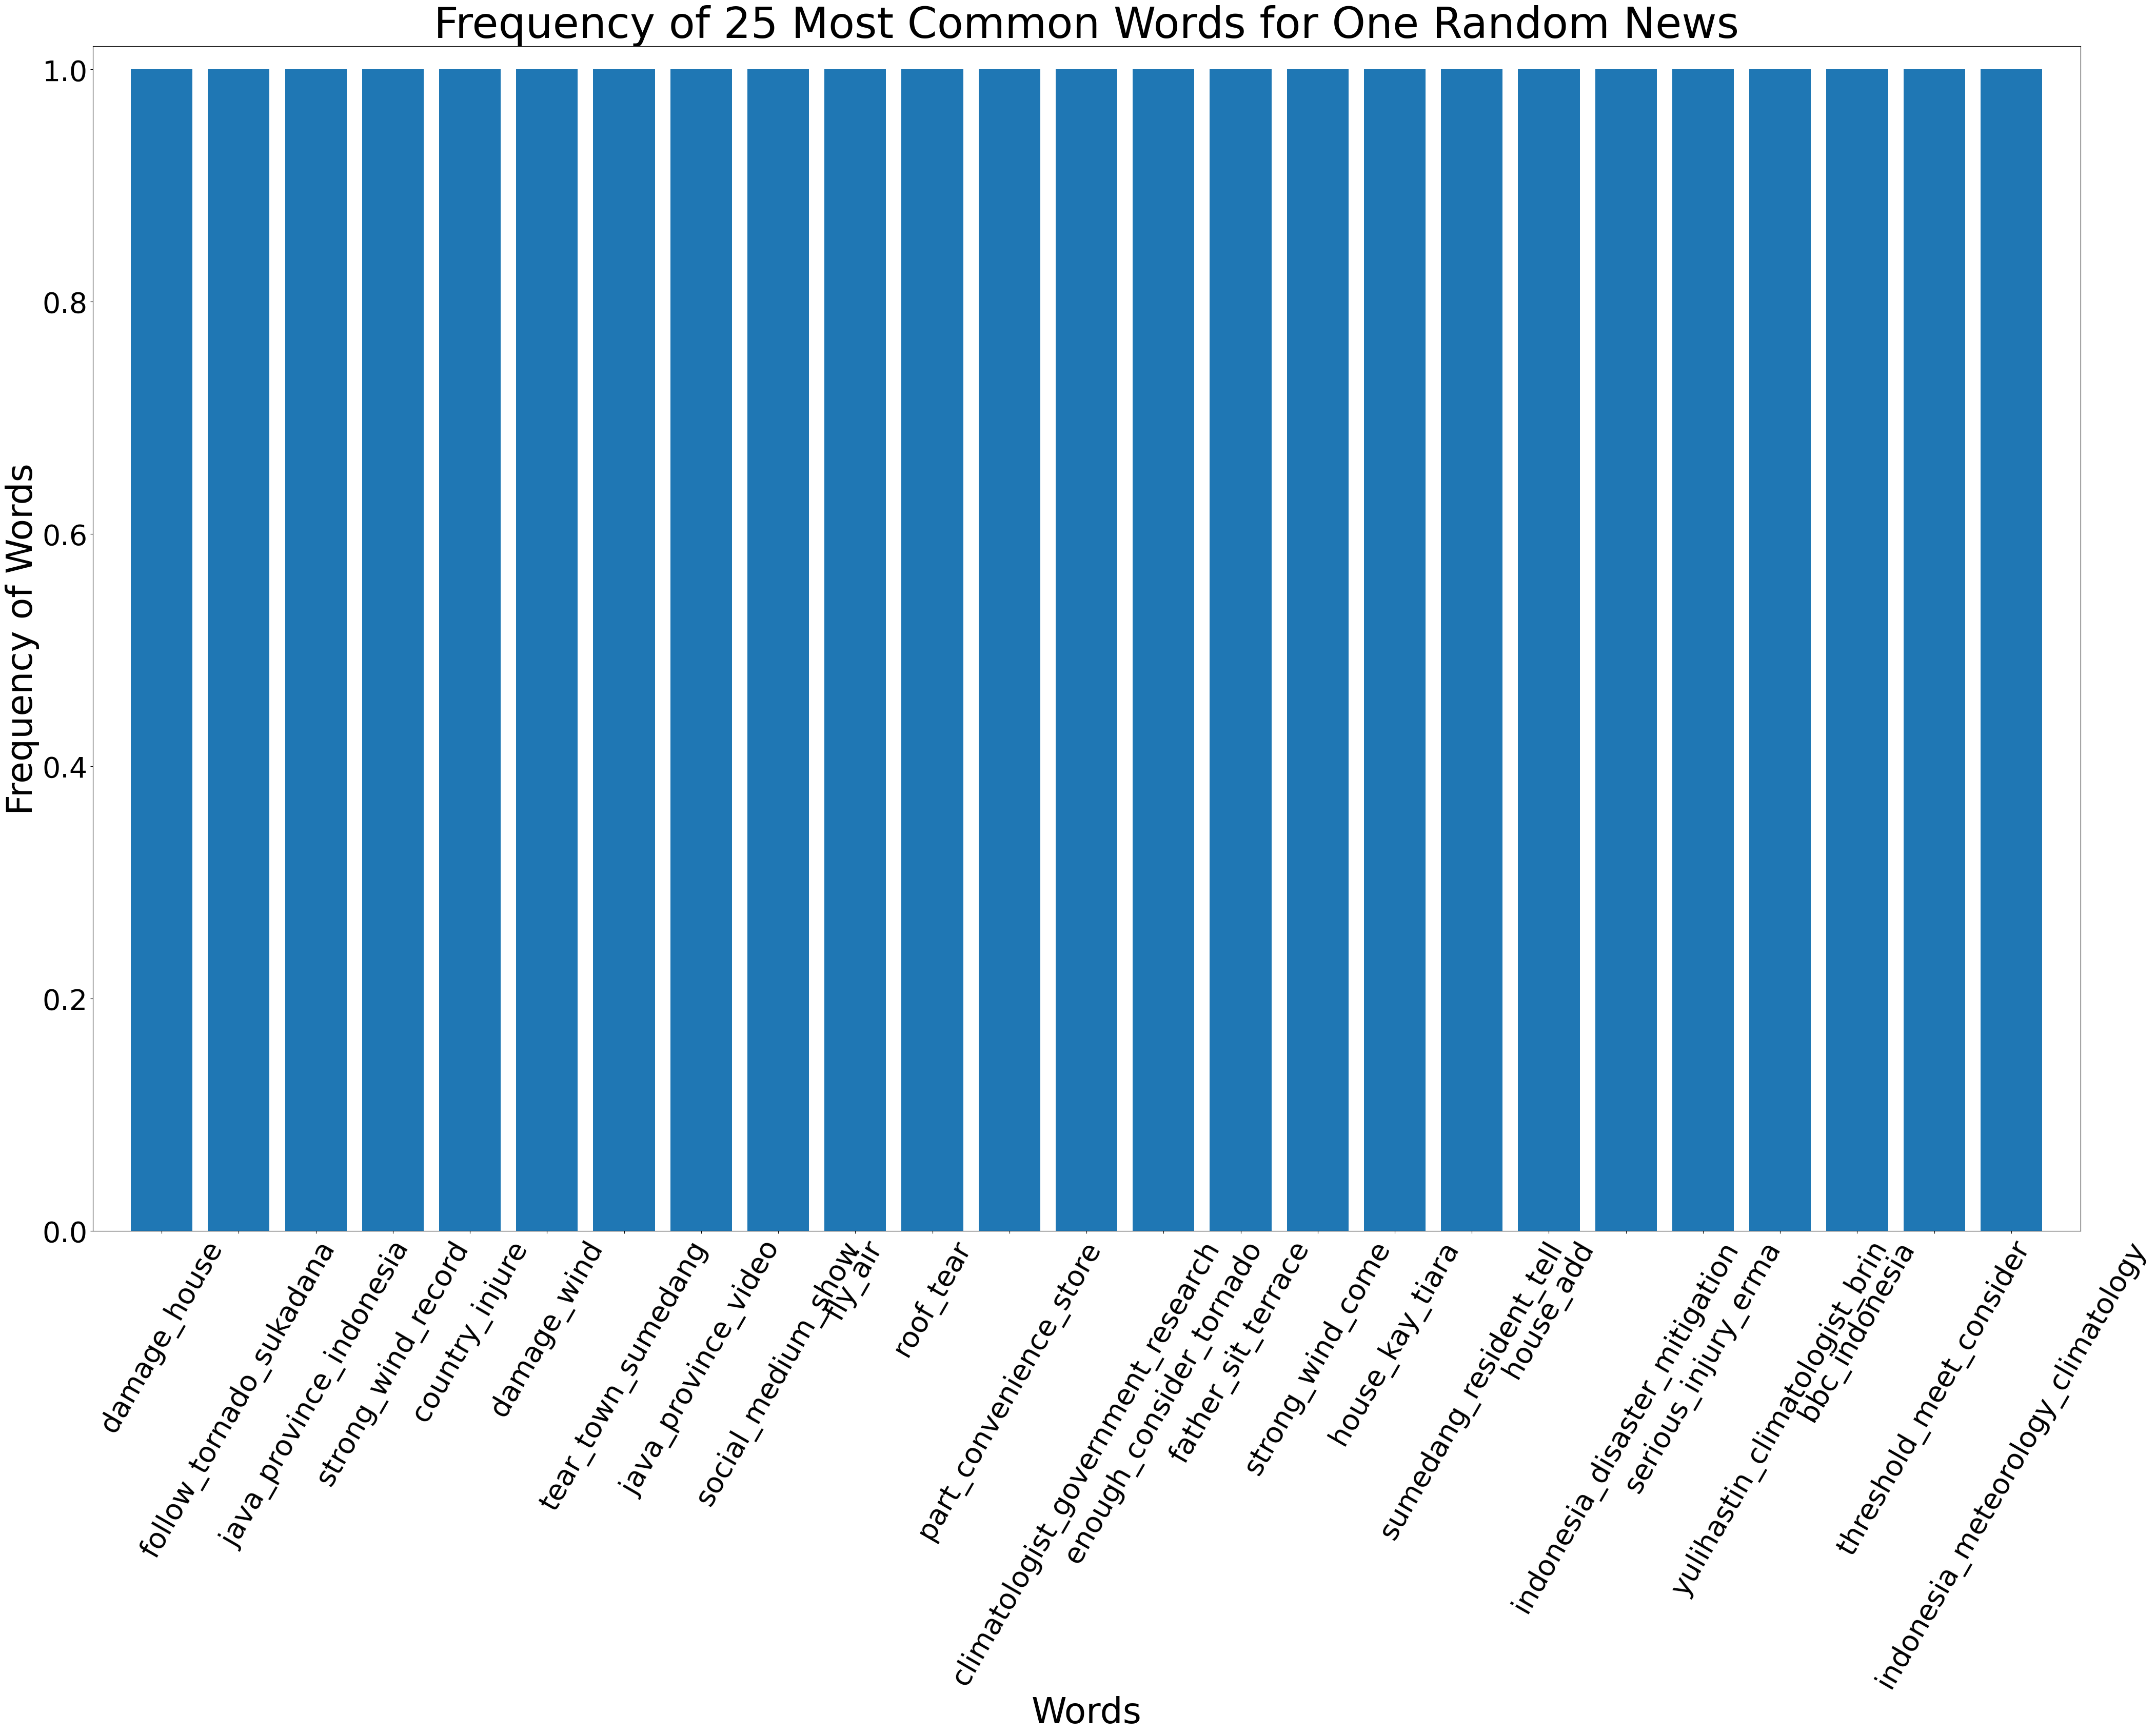

In [30]:
fdist_doc = nltk.FreqDist(df_uni["binary_content"][5]).most_common(25)

x, y = zip(*fdist_doc)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel("Words", fontsize=50)
plt.ylabel("Frequency of Words", fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title("Frequency of 25 Most Common Words for One Random News", fontsize=60)
plt.show()

In [31]:
all_words = [word for sublist in df_uni["binary_content"] for word in sublist]
all_words[:2]
# Calculate word frequencies
fdist = FreqDist(all_words)

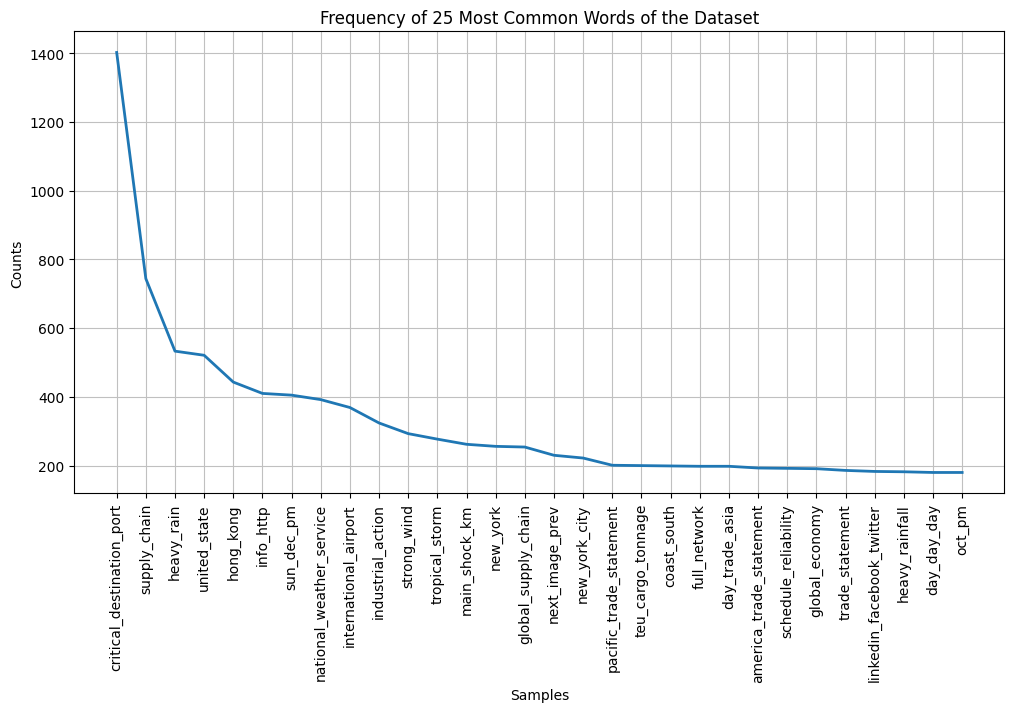

<Axes: title={'center': 'Frequency of 25 Most Common Words of the Dataset'}, xlabel='Samples', ylabel='Counts'>

In [32]:
# Plot the word frequency distribution as a bar graph
plt.figure(figsize=(12, 6))
plt.title("Frequency of 25 Most Common Words of the Dataset", fontsize=12)
fdist.plot(30, cumulative=False)

# Wordcloud

In [33]:
com = df_uni["Severity"].unique()
com[:10]

array(['Moderate', 'Minor', 'Extreme', 'Severe'], dtype=object)

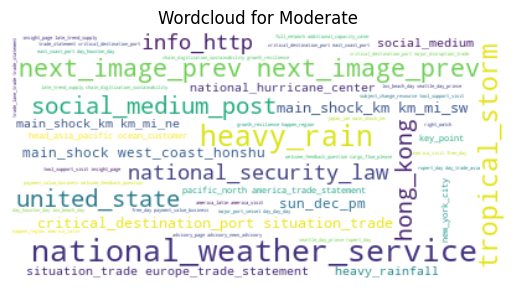

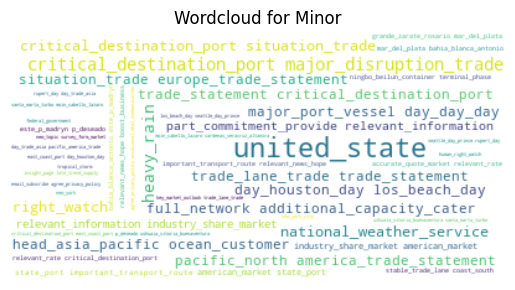

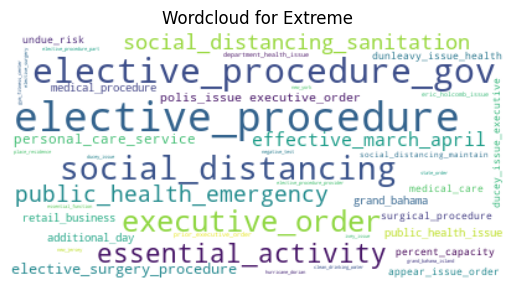

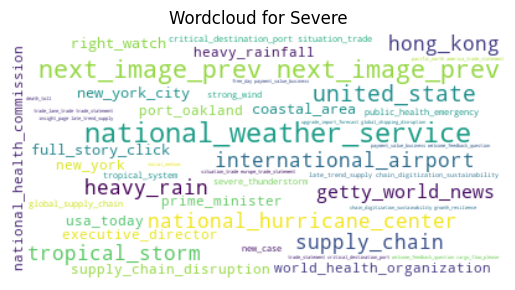

In [34]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Plotting with Seaborn for each company
for region in com[:10]:
    haha = df_uni["binary_content"].loc[df_uni.Severity == region]
    text = " ".join(" ".join(item) for item in haha)
    wordcloud = WordCloud(background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Wordcloud for {region}")
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

## IT-IDF Word Removal

remove those frequently appeared but less important words like say, will, year, use, etc.

In [35]:
df_uni["binary_content"] = df_uni["binary_content"].apply(lambda x: " ".join(x))

# Tokenize the text and create a dictionary
documents = df_uni["binary_content"].str.split()
dictionary = corpora.Dictionary(documents)

tfidf = models.TfidfModel(dictionary=dictionary, normalize=True)
tfidf_corpus = [tfidf[dictionary.doc2bow(doc)] for doc in documents]
term_frequencies = {dictionary[id]: freq for id, freq in tfidf.dfs.items()}

In [36]:
sorted_term_frequencies = dict(
    sorted(term_frequencies.items(), key=lambda item: item[1], reverse=True)
)
sorted_term_frequencies

{'supply_chain': 332,
 'heavy_rain': 279,
 'united_state': 220,
 'strong_wind': 203,
 'linkedin_facebook_twitter': 183,
 'day_day_day': 175,
 'hong_kong': 162,
 'global_supply_chain': 148,
 'national_weather_service': 145,
 'europe_trade_statement': 139,
 'america_trade_statement': 139,
 'social_medium': 137,
 'news_maersk_asia': 137,
 'situation_trade': 137,
 'new_york': 135,
 'major_port_vessel': 133,
 'critical_destination_port': 132,
 'mediterranean_trade_statement': 131,
 'pacific_north': 131,
 'day_houston_day': 127,
 'pacific_trade_statement': 127,
 'industrial_action': 125,
 'schedule_reliability': 123,
 'day_trade_asia': 123,
 'east_coast': 122,
 'international_airport': 120,
 'east_coast_port': 120,
 'los_beach_day': 120,
 'trade_lane_trade': 119,
 'heavy_rainfall': 117,
 'second_half': 116,
 'trade_statement': 114,
 'nansha_chiwan_hong': 114,
 'asia_pacific': 114,
 'new_topic': 113,
 'head_asia_pacific': 113,
 'ocean_customer': 113,
 'tropical_storm': 112,
 'rupert_day': 110

threshold = 0.03 seems to be an appropriate cutoff with variation at +- 0.01 for this set of data.

In [37]:
# customisable, lower threshold, more words retained.
threshold = 0.03


def filter_and_join(tfidf_doc):
    filtered_terms = [dictionary[id] for id, score in tfidf_doc if score >= threshold]
    return filtered_terms


df_uni["binary_content"] = [filter_and_join(doc) for doc in tfidf_corpus]

In [38]:
df_uni["binary_content"]

0       [adkerson_jakarta_try, agreement_freeport_indo...
2       [additional_ripple_effect, avoid_path_typhoon,...
4       [actress_accord, available_day_concert, click_...
5       [bbc_indonesia, climatologist_government_resea...
13      [advise_seek_alternate, affect_richmond, alter...
                              ...                        
5701    [open_area, strong_wind, severe_thunderstorm, ...
5702    [new_zealand, gold_coast, aami_park, accor_sta...
5705    [new_york, coastal_area, national_weather_serv...
5706    [high_wind, national_weather_service, storm_sy...
5708    [dp_world, industrial_action, maritime_operati...
Name: binary_content, Length: 3681, dtype: object

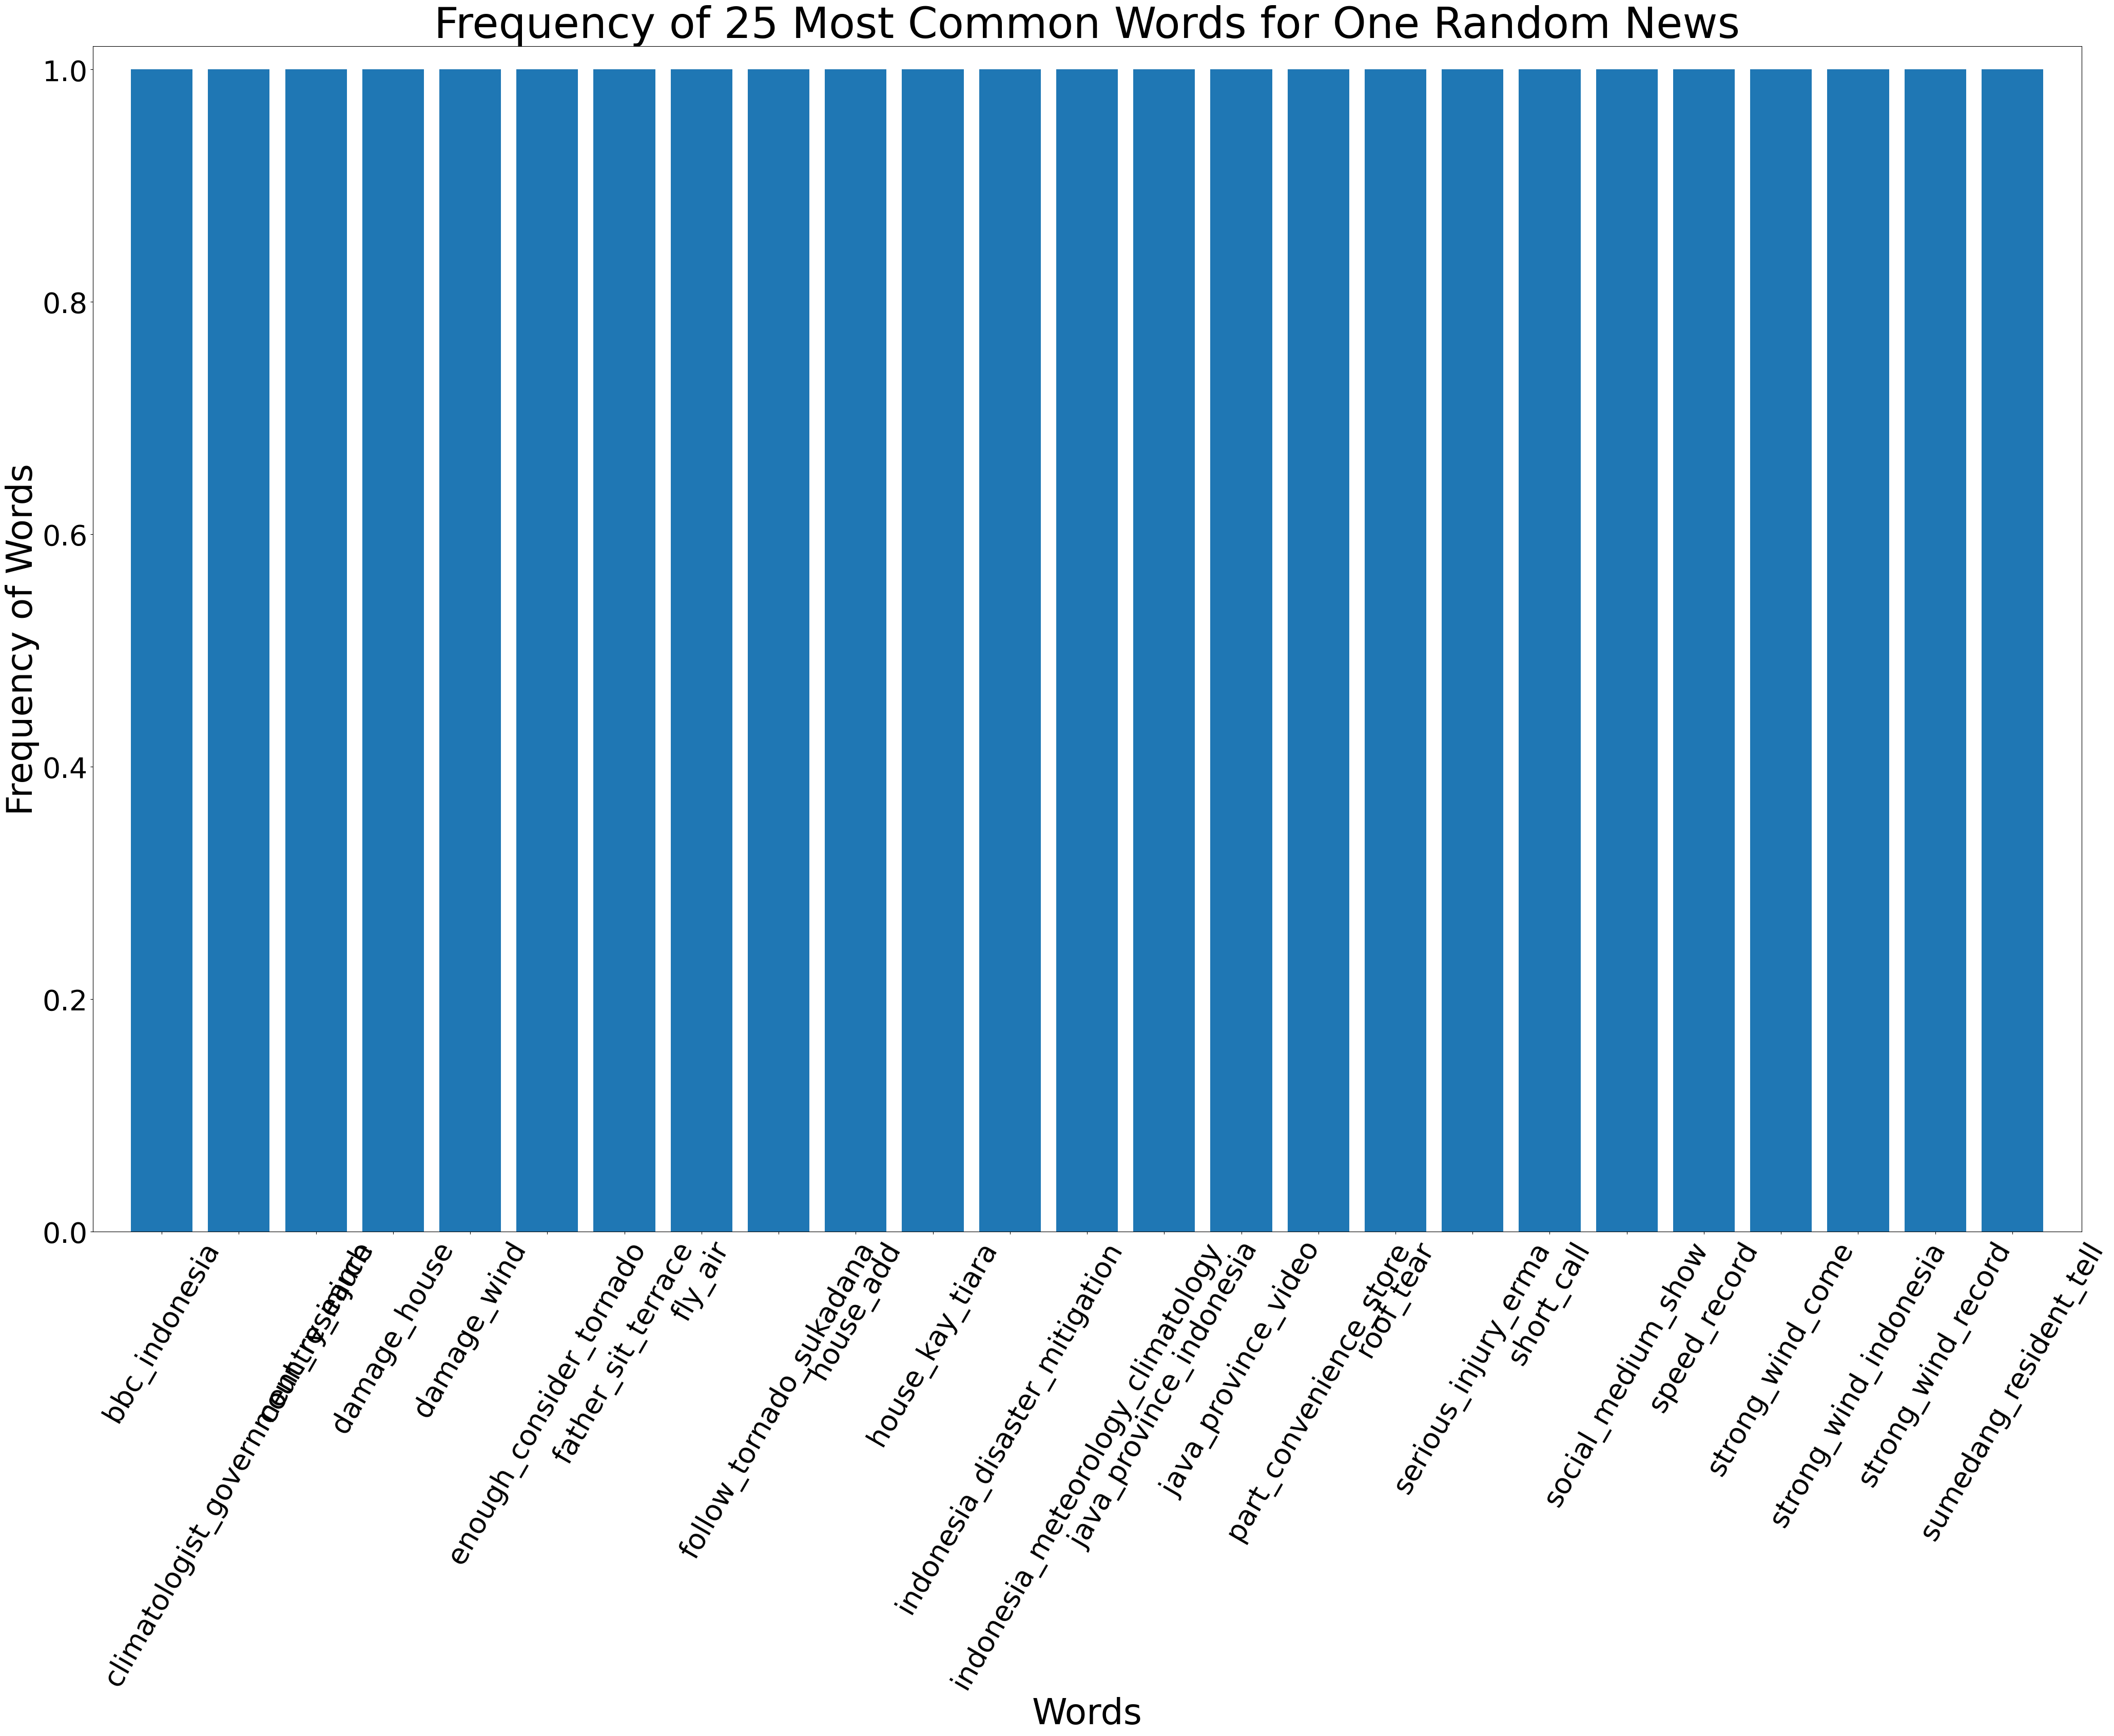

In [39]:
fdist_doc = nltk.FreqDist(df_uni["binary_content"][5]).most_common(25)

x, y = zip(*fdist_doc)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel("Words", fontsize=50)
plt.ylabel("Frequency of Words", fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title("Frequency of 25 Most Common Words for One Random News", fontsize=60)
plt.show()

In [40]:
all_words_filtered = [word for sublist in df_uni["binary_content"] for word in sublist]
all_words_filtered[:2]
# Calculate word frequencies
fdist_filtered = FreqDist(all_words_filtered)

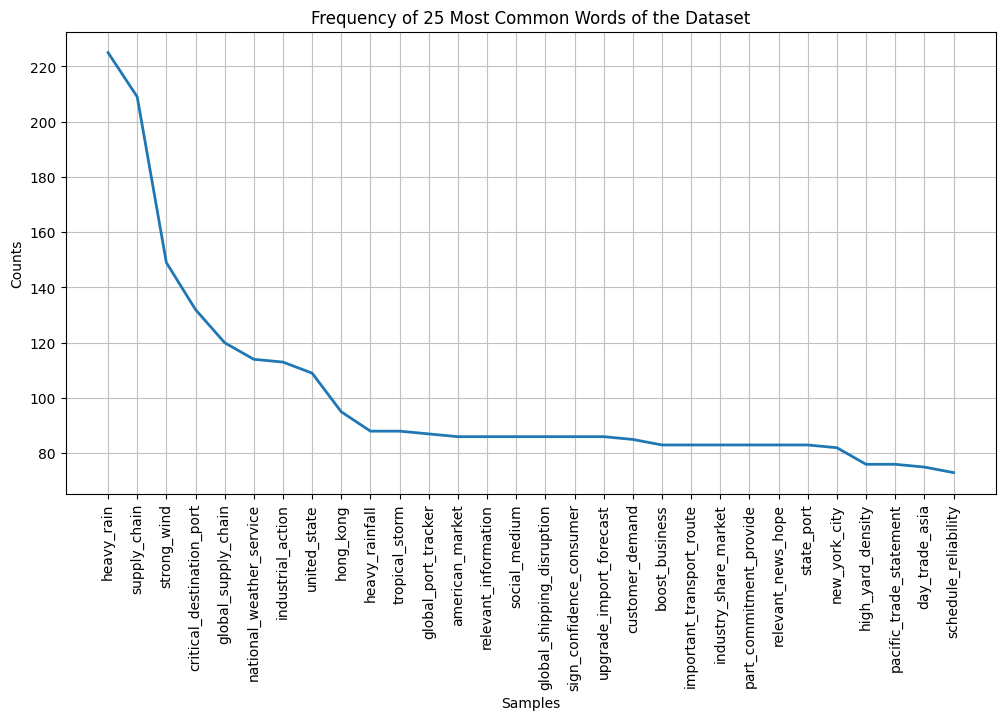

<Axes: title={'center': 'Frequency of 25 Most Common Words of the Dataset'}, xlabel='Samples', ylabel='Counts'>

In [41]:
# Plot the word frequency distribution as a bar graph
# apparently, the dataset is much cleaner now.
plt.figure(figsize=(12, 6))
plt.title("Frequency of 25 Most Common Words of the Dataset", fontsize=12)
fdist_filtered.plot(30, cumulative=False)

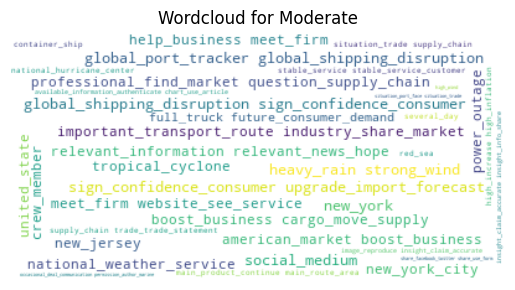

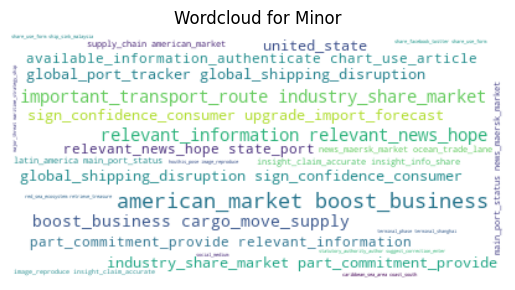

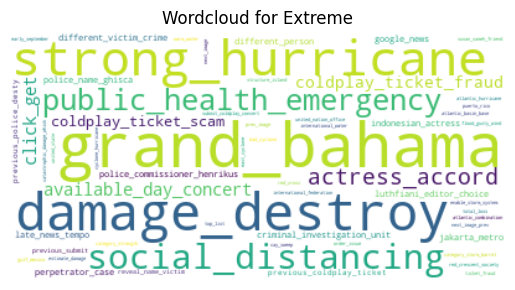

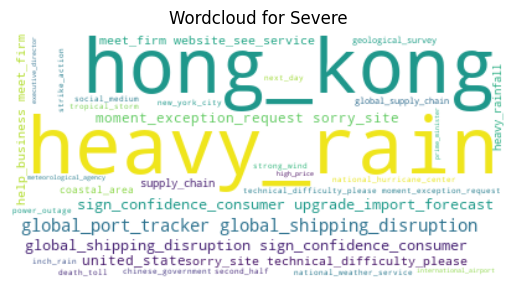

In [42]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Plotting with Seaborn for each company
for region in com[:10]:
    haha = df_uni["binary_content"].loc[df_uni.Severity == region]
    text = " ".join(" ".join(item) for item in haha)
    wordcloud = WordCloud(background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Wordcloud for {region}")
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

In [43]:
df_uni["word_count"] = df_uni["binary_content"].apply(len)

In [44]:
df_uni[["word_count"]].describe().round()

word_count
count      3681.0
mean        115.0
std         135.0
min           1.0
25%          33.0
50%          67.0
75%         131.0
max         819.0

In [45]:
# count of news by region
df_uni[["binary_content", "Region"]].groupby("Region").count().sort_values(
    by="binary_content", ascending=False
)

binary_content
Region                        
United States              549
China                      458
United Kingdom             276
Australia                  271
South Africa               193
...                        ...
Madagascar                   1
Mozambique                   1
Nepal                        1
Nicaragua                    1
Latvia                       1

[100 rows x 1 columns]

In [46]:
df_uni[["binary_content", "Severity"]].groupby("Severity").count().sort_values(
    by="binary_content", ascending=False
)

binary_content
Severity                
Moderate            1761
Minor               1620
Severe               294
Extreme                6

In [47]:
df_uni.head()

id                                           Headline  \
0    1  Grasberg Mine- Grasberg mine workers extend st...   
2    3  Shanghai port congestion impacts terminals in ...   
4    5  UPDATE - Indonesia: Police confirm two explosi...   
5    6  UPDATE - Indonesia: Severe winds damage infras...   
13  14  2 miles E of Chesterfield - A tornado has touc...   

                                              Details  Severity  \
0   Media sources indicate that workers at the Gra...  Moderate   
2   The persisting port congestion at Shanghai’s Y...     Minor   
4   According to local police in Jakarta, two expl...   Extreme   
5   Severe winds have downed billboards and trees ...  Moderate   
13  Government sources are reporting a tornado has...     Minor   

                                             Category         Region  \
0                                 Mine Workers Strike      Indonesia   
2                                     Port Congestion          China   
4                          Bombing, Police Operations      Indonesia   
5   Roadway Closure / Disruption, Flooding, Severe...      Indonesia   
13                                            Tornado  United States   

         Datetime    Year       lat        lon  ...  if_labeled Month  Week  \
0   28/5/17 17:08  2017.0  -4.05608  137.11302  ...       False   5.0  21.0   
2    27/4/17 9:16  2017.0  29.52000  121.33190  ...       False   4.0  17.0   
4   24/5/17 16:20  2017.0       NaN        NaN  ...        True   5.0  21.0   
5    19/4/17 9:10  2017.0  -6.91264  107.65700  ...        True   4.0  16.0   
13  17/9/18 19:55  2018.0  37.51000  -77.61000  ...        True   9.0  38.0   

                                     Headline_Details  \
0   Grasberg Mine- Grasberg mine workers extend st...   
2   Shanghai port congestion impacts terminals in ...   
4   UPDATE - Indonesia: Police confirm two explosi...   
5   UPDATE - Indonesia: Severe winds damage infras...   
13  2 miles E of Chesterfield - A tornado has touc...   

                                                  url  \
0   https://news.google.com/rss/articles/CBMiZ2h0d...   
2   https://news.google.com/rss/articles/CBMiVWh0d...   
4   https://news.google.com/rss/articles/CBMiZWh0d...   
5   https://news.google.com/rss/articles/CBMiSWh0d...   
13  https://news.google.com/rss/articles/CBMigAFod...   

                                                title  \
0   Freeport Indonesia mine workers extend strike ...   
2   Typhoon Muifa to shut China ports for second t...   
4   Jakarta Police Receive 2 More Reports on Coldp...   
5   Indonesia hit by some of strongest winds recorded   
13  UPDATE: Number of homes without power down to ...   

                                              content  \
0   Trucks are seen on a road in the Grasberg copp...   
2   By Sam Whelan 13/09/2022\n\nAnother typhoon ha...   
4   TEMPO.CO, Jakarta - South Jakarta Metro Police...   
5   A man stands near damaged houses following a t...   
13  More than 90,000 homes and businesses across t...   

                                      cleaned_content  \
0   [truck, be, see, on, road, in, grasberg, coppe...   
2   [by, sam, whelan, typhoon, have, prompt, port,...   
4   [jakarta, south, jakarta, metro, police, recei...   
5   [man, stand, near, damage, house, follow, torn...   
13  [more, than, home, business, across, richmond,...   

                                       binary_content word_count  
0   [adkerson_jakarta_try, agreement_freeport_indo...         53  
2   [additional_ripple_effect, avoid_path_typhoon,...         44  
4   [actress_accord, available_day_concert, click_...         24  
5   [bbc_indonesia, climatologist_government_resea...         28  
13  [advise_seek_alternate, affect_richmond, alter...        134  

[5 rows x 23 columns]

In [48]:
df_uni.columns.to_list()

['id',
 'Headline',
 'Details',
 'Severity',
 'Category',
 'Region',
 'Datetime',
 'Year',
 'lat',
 'lon',
 'maritime_label',
 'found_ports',
 'contains_port_info',
 'if_labeled',
 'Month',
 'Week',
 'Headline_Details',
 'url',
 'title',
 'content',
 'cleaned_content',
 'binary_content',
 'word_count']

In [49]:
# export as parquet data file instead of csv for easier list extraction
df_uni.to_parquet("data/processed_data2.parquet", index=False)